# Comparing Pangenome pipeline predictions - Shaw2021 - 50 e. coli genomes

### Import Statements

In [32]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

#### Pandas Viewing Settings

In [33]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [34]:
from panqc.utils import get_PG_Stats_FromPresAbs


# Define Functions

In [35]:
def parse_PresAbs_Rtab_V2(PresAbs_Rtab_PATH):
    '''
    This function parsesthe `gene_presence_absence.csv` file output by Panaroo '''

    i_Gene_PresAbs_DF = pd.read_csv(PresAbs_Rtab_PATH, sep = "\t")

    ### Relabel Columns for presence/absence tracking
    i_Gene_PresAbs_DF.columns = [ x.split(".CDHIT")[0] for x in i_Gene_PresAbs_DF.columns ]


    ListOf_SampleID_Cols = list(i_Gene_PresAbs_DF.drop(["Gene"], axis=1).columns)
    
    i_Gene_PresAbs_DF["NumAsm_WiGene"] = i_Gene_PresAbs_DF[ListOf_SampleID_Cols].sum(axis = 1)

    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.sort_values(by='NumAsm_WiGene', ascending=False)
    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.set_index("Gene", drop=False)

    return i_Gene_PresAbs_DF

In [36]:
def infer_PG_Stats_FromRtab(i_Pangene_Rtab, i_NumSamples, verbose = False):

    Pangene_Rtab_DF = parse_PresAbs_Rtab_V2(i_Pangene_Rtab)

    NumTotalGenes, NumCoreGenes, NumAccessoryGenes = get_PG_Stats_FromPresAbs(Pangene_Rtab_DF, i_NumSamples)

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    Pangene_PG_Stats_DF = pd.DataFrame(listOf_PG_Rows)
    Pangene_PG_Stats_DF.columns = ["Category", "Range", "GeneCount"]
    
    return Pangene_PG_Stats_DF

In [37]:

def read_PanarooSummaryStats(input_Panaroo_SummaryStats_TXT):
    
    i_Panaroo_Stats_DF = pd.read_csv(input_Panaroo_SummaryStats_TXT, sep = "\t", header=None)
    i_Panaroo_Stats_DF.columns = ["Category", "Range", "GeneCount"]

    Acc_GenesCount = i_Panaroo_Stats_DF["GeneCount"].values[-1] - i_Panaroo_Stats_DF["GeneCount"].values[0]

    i_Panaroo_AccGenesRow = ["Accessory genes","(0% <= strains < 99%)", Acc_GenesCount]

    i_Panaroo_Stats_DF.loc[len(i_Panaroo_Stats_DF.index)] = i_Panaroo_AccGenesRow

    #listOfCat_ToKeep = ["Core genes", "Accessory Genes", "Total genes"]

    i_Panaroo_Stats_DF = i_Panaroo_Stats_DF[ i_Panaroo_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

    # https://www.statology.org/pandas-add-row-to-dataframe/#:~:text=You%20can%20use%20the%20df,loc%5Blen(df. 

    return i_Panaroo_Stats_DF

In [38]:
def read_Ppanggolin_ContextStats(i_Ppanggolin_Default_Content_TXT):
    with open(i_Ppanggolin_Default_Content_TXT, "r") as f:

        #NumCoreGenes = -1
        #NumShellGenes = -1
        #NumCloudGenes = -1
        for line in f:
            line_split = line.split(": ")

            Key = line_split[0].split(" (")[0]
            Value = line_split[-1].strip()

            if Key == "Persistent": NumCoreGenes = int(Value)
            elif Key == "Shell": NumShellGenes = int(Value)
            elif Key == "Cloud": NumCloudGenes = int(Value)

        NumAccessoryGenes = NumShellGenes + NumCloudGenes
        NumTotalGenes = NumCoreGenes + NumAccessoryGenes

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    PPanggolin_Summary_DF = pd.DataFrame(listOf_PG_Rows)
    PPanggolin_Summary_DF.columns = ["Category", "Range", "GeneCount"]
    
    return PPanggolin_Summary_DF

In [39]:

def calculate_gene_gain_loss_stats(branchstats_tsv):
    """
    Calculate gene gain and loss statistics for ancestral branches and tips
    from a branchstats.tsv file generated by Panstripe software.
    
    Parameters:
        branchstats_tsv (str): Path to the branchstats.tsv file.
        
    Returns:
        dict: A dictionary containing the four statistics:
              - N_Gain_AncBranches: Total number of genes gained on ancestral branches.
              - N_Loss_AncBranches: Total number of genes lost on ancestral branches.
              - N_Gain_Tips: Total number of genes gained on tips.
              - N_Loss_Tips: Total number of genes lost on tips.
    """
    # Load the data
    data = pd.read_csv(branchstats_tsv, sep="\t")
    
    # Split the data into ancestral branches and tips
    data_tips = data.query("istip == 1")
    data_ancs = data.query("istip == 0")
    
    # Calculate statistics
    stats = {
        "N_Gain_Ancs": data_ancs["acc_gain"].sum(),
        "N_Loss_Ancs": data_ancs["acc_loss"].sum(),
        "N_Gain_Tips": data_tips["acc_gain"].sum(),
        "N_Loss_Tips": data_tips["acc_loss"].sum()
    }
    
    return stats

# Example usage:
# file_path = "path/to/Panstripe.BranchStats.tsv"
# stats = calculate_gene_gain_loss_stats(file_path)
# print(stats)


## Define paths to sample metadata files & key directories

In [40]:

Proj_MainDir = "/n/data1/hms/dbmi/farhat/mm774/Projects"

Ecoli_PG_MainDir = f"{Proj_MainDir}/230905_Ecoli_PG_Analysis"  

Data_MainDir = f"{Ecoli_PG_MainDir}/Data"  

Shaw2021_50Asm_Dir = f"{Data_MainDir}/Shaw2021.50Genomes.Data/data"

Shaw2021_Meta_TSV = f"{Data_MainDir}/Shaw2021.SelectedIsolates.50I.tsv"  

input_FA_PATH_TSVs_Dir = f"{Ecoli_PG_MainDir}/input_PATH_SMK_TSVs"

Ecoli_Meta_Dir = f"../../Data/230905_Ecoli_50CI_Metadata_Shaw2021"  

Shaw2021_Ecoli_50Asm_Meta_TSV = f"{Ecoli_Meta_Dir}/231011.Shaw2021.Ecoli.50I.MetaData.tsv"


## Parse in metadata DFs

In [41]:
Shaw_50A_Info_DF = pd.read_csv(Shaw2021_Ecoli_50Asm_Meta_TSV, sep = "\t")
Shaw_50A_Info_DF.shape

(50, 24)

### Define list of SampleIDs

In [42]:
Shaw_50A_Info_DF.head(1)  

,Isolate,Biosample Accession,Short Reads Accession,Long Reads Accession,Assembly Accession,Animal or WwTW,Isolate source information,Timepoint,Niche,Niche.2,Location,Genus,Species,ST assignment,Circularised plasmids,Number of contigs,Circularised chromosome (1=yes),Total genome size (bp),Chromosome GC (if known),Phylogroup (E. coli only),Alternative isolate name,Long read sequencing method,SampleID,Genome_ASM_PATH
0,RH02|T1-C02,SAMN15147960,SRR11948863,SRR12299015,GCA_014109125.1,Animal,Pooled pig faecal samples collected from floor...,1,Pig,Faeces,RH02,Escherichia,Escherichia coli,10.0,1,2,1,4953790,50.7,A,RHB02-C02,PacBio,GCA_014109125,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...


In [43]:
E50I_SampleIDs = Shaw_50A_Info_DF["SampleID"].values   
len(E50I_SampleIDs)

50

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [44]:
# Define genome analysis and pan-genome pipeline output directories

WGA_SMK_Outputs_Dir = f"{Ecoli_PG_MainDir}/SMK_OutDirs"

PG_Ecoli_50I_OutDir = WGA_SMK_Outputs_Dir + "/231011_Ecoli_Shaw2021_5OI_V1"


In [45]:
#!ls -alh $PG_Ecoli_50I_OutDir

# Define output files & parse results for each pipeline

In [46]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',
                         "Ppanggolin_I0.80C0.60",
                         "Ppanggolin_I0.80C0.80",
                         "Ppanggolin_I0.80C0.90",
                         "Ppanggolin_I0.90C0.60",
                         "Ppanggolin_I0.90C0.80",
                         "Ppanggolin_I0.90C0.90",
                         "Ppanggolin_I0.98C0.60",
                         "Ppanggolin_I0.98C0.80",
                         "Ppanggolin_I0.98C0.90",
                         'Pangene_0.9.Miniprot0.95',
                         'Pangene_0.9.Miniprot0.98',
                         'Pangene_0.9.Miniprot0.99',
                         'Pangene_0.9.Miniprot0.9',
                         'Pangene_0.95.Miniprot0.95',
                         'Pangene_0.95.Miniprot0.98',
                         'Pangene_0.95.Miniprot0.99',
                         'Pangene_0.95.Miniprot0.9',
                         'Pangene_0.98.Miniprot0.95',
                         'Pangene_0.98.Miniprot0.98',
                         'Pangene_0.98.Miniprot0.99',
                         'Pangene_0.98.Miniprot0.9',] 

# PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
#                          'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict','Panaroo_Moderate', 'Panaroo_Sensitive',
#                          'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
#                          'Roary_NoSplitParalogs',  'Roary_Default', 'Ppanggolin_Default',]



target_OutputDir = PG_Ecoli_50I_OutDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"

listOfCat_ToKeep = ["Core genes", "Accessory genes", "Total genes"]


dictOf_PG_OutInfo = {}
dictOf_PG_PresAbs_DF = {}
dictOf_PG_OutDir_PATHs = {}

for i_SampleSet in ["All"]:
    
    dictOf_PG_OutInfo[i_SampleSet] = {}
    dictOf_PG_OutDir_PATHs[i_SampleSet] = {}
    dictOf_PG_PresAbs_DF[i_SampleSet] = {}
    
    for AnnoPipeline in ["Bakta"]:
        
        dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline] = {}
        
        for AsmTech in ["LongRead", "ShortRead"]:       
        #for AsmTech in ["LongRead"]:       

            dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech] = {}
            
            
            for i_PipeNameWiParam in tqdm(PipeName_WiParam_List):
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = {}
                
                if (AsmTech == "ShortRead") & (AnnoPipeline == "PGAP"): continue 
                
                if i_SampleSet == "All": DataSetSuffix = "_AllIsolates"  

                if AsmTech == "LongRead": SeqTechPrefix = ""
                elif AsmTech == "ShortRead": SeqTechPrefix = "SR_"

                if AnnoPipeline == "Bakta": AnnoSuffix = ""


                i_Pipeline_OutDir = f"{i_Pangenome_Dir}/"+SeqTechPrefix+i_PipeNameWiParam+DataSetSuffix+AnnoSuffix

                i_Pangene_OutDir  = f"{i_Pangenome_Dir}/Pangene/{SeqTechPrefix}{i_PipeNameWiParam}{DataSetSuffix}{AnnoSuffix}"

                if "Pangene" in i_PipeNameWiParam:
                    
                    Pangene_ParamString = i_PipeNameWiParam[8:]
                    # i_PipeNameWiParam
                    print(Pangene_ParamString)
                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pangene_OutDir}/{SeqTechPrefix}{i_PipeNameWiParam}.gene_presence_absence.Rtab"    

                    i_PG_Stats_DF = infer_PG_Stats_FromRtab(i_Gene_PresAbs_Rtab_PATH, 50)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    
                    i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"    

                    # GainLoss_Stats = calculate_gene_gain_loss_stats(i_Panstripe_BranchStats_TSV_PATH)
                    # i_PG_Stats_DF["N_Gain_Ancs"] = GainLoss_Stats["N_Gain_Ancs"]
                    # i_PG_Stats_DF["N_Loss_Ancs"] = GainLoss_Stats["N_Loss_Ancs"]
                    # i_PG_Stats_DF["N_Gain_Tips"] = GainLoss_Stats["N_Gain_Tips"]
                    # i_PG_Stats_DF["N_Loss_Tips"] = GainLoss_Stats["N_Loss_Tips"]

              
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_Rtab"] = i_Gene_PresAbs_Rtab_PATH
                
                
                if "Panaroo" in i_PipeNameWiParam:
                    
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    
                    i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"    

                    # GainLoss_Stats = calculate_gene_gain_loss_stats(i_Panstripe_BranchStats_TSV_PATH)
                    # i_PG_Stats_DF["N_Gain_Ancs"] = GainLoss_Stats["N_Gain_Ancs"]
                    # i_PG_Stats_DF["N_Loss_Ancs"] = GainLoss_Stats["N_Loss_Ancs"]
                    # i_PG_Stats_DF["N_Gain_Tips"] = GainLoss_Stats["N_Gain_Tips"]
                    # i_PG_Stats_DF["N_Loss_Tips"] = GainLoss_Stats["N_Loss_Tips"]

                    
                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    
                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"
                    
                    #i_Gene_PresAbs_DF = parse_Panaroo_GenePresAbs_CSV(i_Gene_PresAbs_CSV_PATH)  

                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH


                elif "Roary" in i_PipeNameWiParam:
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"    

                    # GainLoss_Stats = calculate_gene_gain_loss_stats(i_Panstripe_BranchStats_TSV_PATH)
                    # i_PG_Stats_DF["N_Gain_Ancs"] = GainLoss_Stats["N_Gain_Ancs"]
                    # i_PG_Stats_DF["N_Loss_Ancs"] = GainLoss_Stats["N_Loss_Ancs"]
                    # i_PG_Stats_DF["N_Gain_Tips"] = GainLoss_Stats["N_Gain_Tips"]
                    # i_PG_Stats_DF["N_Loss_Tips"] = GainLoss_Stats["N_Loss_Tips"]

                    
                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    

                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"
                    
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH

                elif "Ppanggolin" in i_PipeNameWiParam:

                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    

                    i_PG_Stats_DF = infer_PG_Stats_FromRtab(i_Gene_PresAbs_Rtab_PATH, 50)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                                        
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)


                    i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"    

                    # GainLoss_Stats = calculate_gene_gain_loss_stats(i_Panstripe_BranchStats_TSV_PATH)
                    # i_PG_Stats_DF["N_Gain_Ancs"] = GainLoss_Stats["N_Gain_Ancs"]
                    # i_PG_Stats_DF["N_Loss_Ancs"] = GainLoss_Stats["N_Loss_Ancs"]
                    # i_PG_Stats_DF["N_Gain_Tips"] = GainLoss_Stats["N_Gain_Tips"]
                    # i_PG_Stats_DF["N_Loss_Tips"] = GainLoss_Stats["N_Loss_Tips"]

                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    
                    
                                          
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_Rtab"] = i_Gene_PresAbs_Rtab_PATH


                dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_PG_Stats_DF
                
                #dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_Gene_PresAbs_DF
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Stats_TXT"] = i_PG_Summary_Txt

 32%|███▏      | 10/31 [00:00<00:00, 93.82it/s]

Accessory Thresh: 49.5
Accessory Thresh: 49.5


 42%|████▏     | 13/31 [00:00<00:00, 23.08it/s]

Accessory Thresh: 49.5
Accessory Thresh: 49.5


 52%|█████▏    | 16/31 [00:00<00:01, 14.58it/s]

Accessory Thresh: 49.5
Accessory Thresh: 49.5


 58%|█████▊    | 18/31 [00:01<00:01,  9.99it/s]

Accessory Thresh: 49.5
Accessory Thresh: 49.5


 65%|██████▍   | 20/31 [00:01<00:01,  8.74it/s]

Accessory Thresh: 49.5
0.9.Miniprot0.95
Accessory Thresh: 49.5
0.9.Miniprot0.98


 71%|███████   | 22/31 [00:01<00:00,  9.10it/s]

Accessory Thresh: 49.5
0.9.Miniprot0.99
Accessory Thresh: 49.5
0.9.Miniprot0.9
Accessory Thresh: 49.5


 77%|███████▋  | 24/31 [00:01<00:00,  9.38it/s]

0.95.Miniprot0.95
Accessory Thresh: 49.5
0.95.Miniprot0.98
Accessory Thresh: 49.5


 84%|████████▍ | 26/31 [00:02<00:00,  9.19it/s]

0.95.Miniprot0.99
Accessory Thresh: 49.5
0.95.Miniprot0.9
Accessory Thresh: 49.5
0.98.Miniprot0.95


 90%|█████████ | 28/31 [00:02<00:00,  9.25it/s]

Accessory Thresh: 49.5
0.98.Miniprot0.98
Accessory Thresh: 49.5
0.98.Miniprot0.99


  0%|          | 0/31 [00:00<?, ?it/s]

Accessory Thresh: 49.5
0.98.Miniprot0.9
Accessory Thresh: 49.5


 32%|███▏      | 10/31 [00:00<00:00, 96.02it/s]

Accessory Thresh: 49.5
Accessory Thresh: 49.5


 42%|████▏     | 13/31 [00:00<00:00, 24.13it/s]

Accessory Thresh: 49.5
Accessory Thresh: 49.5


 52%|█████▏    | 16/31 [00:00<00:01, 14.70it/s]

Accessory Thresh: 49.5
Accessory Thresh: 49.5


 58%|█████▊    | 18/31 [00:01<00:01, 10.07it/s]

Accessory Thresh: 49.5
Accessory Thresh: 49.5


 65%|██████▍   | 20/31 [00:01<00:01,  9.16it/s]

Accessory Thresh: 49.5
0.9.Miniprot0.95
Accessory Thresh: 49.5
0.9.Miniprot0.98
Accessory Thresh: 49.5


 71%|███████   | 22/31 [00:01<00:00,  9.59it/s]

0.9.Miniprot0.99
Accessory Thresh: 49.5
0.9.Miniprot0.9
Accessory Thresh: 49.5
0.95.Miniprot0.95


 77%|███████▋  | 24/31 [00:01<00:00,  9.89it/s]

Accessory Thresh: 49.5
0.95.Miniprot0.98
Accessory Thresh: 49.5
0.95.Miniprot0.99
Accessory Thresh: 49.5


 90%|█████████ | 28/31 [00:02<00:00, 10.29it/s]

0.95.Miniprot0.9
Accessory Thresh: 49.5
0.98.Miniprot0.95
Accessory Thresh: 49.5
0.98.Miniprot0.98


 97%|█████████▋| 30/31 [00:02<00:00, 10.45it/s]

Accessory Thresh: 49.5
0.98.Miniprot0.99
Accessory Thresh: 49.5
0.98.Miniprot0.9
Accessory Thresh: 49.5


100%|██████████| 31/31 [00:02<00:00, 12.55it/s]


In [47]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"] 

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All


In [48]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Pangene_0.98.Miniprot0.99"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Total genes,(0% <= strains <= 100%),13190,Bakta,Pangene_0.98.Miniprot0.99,LongRead,All
1,Accessory genes,(0% <= strains < 99%),10171,Bakta,Pangene_0.98.Miniprot0.99,LongRead,All
2,Core genes,(99% <= strains <= 100%),3019,Bakta,Pangene_0.98.Miniprot0.99,LongRead,All


In [49]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Pangene_0.95.Miniprot0.95"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Total genes,(0% <= strains <= 100%),12787,Bakta,Pangene_0.95.Miniprot0.95,LongRead,All
1,Accessory genes,(0% <= strains < 99%),9757,Bakta,Pangene_0.95.Miniprot0.95,LongRead,All
2,Core genes,(99% <= strains <= 100%),3030,Bakta,Pangene_0.95.Miniprot0.95,LongRead,All


In [50]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/PanGenome_Analysis/Pangene/


Bakta.AllCDSMerged.faa
CD-HIT_Clustering_Bakta
Miniprot
Pangene_0.95.Miniprot0.95_AllIsolates
Pangene_0.95.Miniprot0.98_AllIsolates
Pangene_0.95.Miniprot0.99_AllIsolates
Pangene_0.95.Miniprot0.9_AllIsolates
Pangene_0.98.Miniprot0.95_AllIsolates
Pangene_0.98.Miniprot0.98_AllIsolates
Pangene_0.98.Miniprot0.99_AllIsolates
Pangene_0.98.Miniprot0.9_AllIsolates
Pangene_0.9.Miniprot0.95_AllIsolates
Pangene_0.9.Miniprot0.98_AllIsolates
Pangene_0.9.Miniprot0.99_AllIsolates
Pangene_0.9.Miniprot0.9_AllIsolates
SRAsms.Bakta.AllCDSMerged.faa
SR_Pangene_0.95.Miniprot0.95_AllIsolates
SR_Pangene_0.95.Miniprot0.98_AllIsolates
SR_Pangene_0.95.Miniprot0.99_AllIsolates
SR_Pangene_0.95.Miniprot0.9_AllIsolates
SR_Pangene_0.98.Miniprot0.95_AllIsolates
SR_Pangene_0.98.Miniprot0.98_AllIsolates
SR_Pangene_0.98.Miniprot0.99_AllIsolates
SR_Pangene_0.98.Miniprot0.9_AllIsolates
SR_Pangene_0.9.Miniprot0.95_AllIsolates
SR_Pangene_0.9.Miniprot0.98_AllIsolates
SR_Pangene_0.9.Miniprot0.99_AllIsolates
SR_Pangene_0.9.Mini

In [51]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/PanGenome_Analysis/Pangene/SR_Pangene_0.9.Miniprot0.95_AllIsolates

SR_Pangene_0.9.Miniprot0.95.gene_presence_absence.Rtab
SR_Pangene_0.9.Miniprot0.95.gfa


In [52]:
#dictOf_PG_OutInfo["All"]["Bakta"]["ShortRead"]["Panaroo_Strict_MergeParalogs"]


In [53]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Ppanggolin_I0.80C0.80"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Total genes,(0% <= strains <= 100%),14380,Bakta,Ppanggolin_I0.80C0.80,LongRead,All
1,Accessory genes,(0% <= strains < 99%),11371,Bakta,Ppanggolin_I0.80C0.80,LongRead,All
2,Core genes,(99% <= strains <= 100%),3009,Bakta,Ppanggolin_I0.80C0.80,LongRead,All


In [54]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Pangene_0.98.Miniprot0.99"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Total genes,(0% <= strains <= 100%),13190,Bakta,Pangene_0.98.Miniprot0.99,LongRead,All
1,Accessory genes,(0% <= strains < 99%),10171,Bakta,Pangene_0.98.Miniprot0.99,LongRead,All
2,Core genes,(99% <= strains <= 100%),3019,Bakta,Pangene_0.98.Miniprot0.99,LongRead,All


In [55]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/PanGenome_Analysis/Pangene/Pangene_0.9.Miniprot0.95_AllIsolates/


Pangene_0.9.Miniprot0.95.gene_presence_absence.Rtab
Pangene_0.9.Miniprot0.95.gfa


# 1) Merge all Pan-genome counts accross all combinations evaluated

In [56]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',
                         "Ppanggolin_I0.80C0.60",
                         "Ppanggolin_I0.80C0.80",
                         "Ppanggolin_I0.80C0.90",
                         "Ppanggolin_I0.90C0.60",
                         "Ppanggolin_I0.90C0.80",
                         "Ppanggolin_I0.90C0.90",
                         "Ppanggolin_I0.98C0.60",
                         "Ppanggolin_I0.98C0.80",
                         "Ppanggolin_I0.98C0.90",
                         'Pangene_0.9.Miniprot0.95',
                         'Pangene_0.9.Miniprot0.98',
                         'Pangene_0.9.Miniprot0.99',
                         'Pangene_0.9.Miniprot0.9',
                         'Pangene_0.95.Miniprot0.95',
                         'Pangene_0.95.Miniprot0.98',
                         'Pangene_0.95.Miniprot0.99',
                         'Pangene_0.95.Miniprot0.9',
                         'Pangene_0.98.Miniprot0.95',
                         'Pangene_0.98.Miniprot0.98',
                         'Pangene_0.98.Miniprot0.99',
                         'Pangene_0.98.Miniprot0.9',] 


listOf_PG_InfoDFs = []
for i_SampleSet in ["All"]: 
    for AnnoPipeline in ["Bakta"]:
        #for AsmTech in ["LongRead"]:
        for AsmTech in ["LongRead", "ShortRead"]:
            for i_PipeNameWiParam in PipeName_WiParam_List:
                i_PG_Stats_DF = dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]
                
                listOf_PG_InfoDFs.append(i_PG_Stats_DF)


PG_Merged_Stats_LRandSR_DF = pd.concat(listOf_PG_InfoDFs)

PG_Merged_Stats_LRandSR_DF["MethodAndTech"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["MethodAndTechAndAnno"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]  + "_" +PG_Merged_Stats_LRandSR_DF["Annotation"]  

PG_Merged_Stats_LRandSR_DF["AnnoAndTech"] = PG_Merged_Stats_LRandSR_DF["Annotation"] + "-" + PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["PangenomeTool"] = PG_Merged_Stats_LRandSR_DF["Method"].str.split("_").str[0]

PG_Merged_Stats_LRandSR_DF.shape


(186, 11)

In [57]:
PG_Merged_Stats_LRandSR_DF["PangenomeTool"].value_counts()

Pangene       72
Ppanggolin    54
Panaroo       36
Roary         24
Name: PangenomeTool, dtype: int64

In [58]:
PG_Merged_Stats_LRandSR_DF.shape

(186, 11)

## Divide Pan-genome summary stats by "assembly type" and "gene category"

In [59]:
PG_Merged_Stats_LRandSR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ")
PG_Merged_Stats_LRandSR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ")
PG_Merged_Stats_LRandSR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ")

In [60]:
PG_Merged_Stats_LR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'LongRead'  ")

In [61]:
PG_Merged_Stats_SR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'ShortRead'  ")
PG_Merged_Stats_SR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'ShortRead'  ")
PG_Merged_Stats_SR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'ShortRead'  ")

In [62]:
# PG_Merged_Stats_LR_DF = pd.concat([Panaroo_Strict_Stats_DF,
#                                 Panaroo_Moderate_Stats_DF,
#                                 Panaroo_Sensitive_Stats_DF,
#                                 Roary_Default_Stats_DF,
#                                 Roary_NoSplit_Stats_DF,
#                                 Roary_NoSplitI90_Stats_DF,
#                                 Ppanggolin_Default_Stats_DF])

# PG_Merged_Stats_LR_DF.shape

### Explore data structure a bit

In [63]:
PG_Merged_Stats_LRandSR_DF.head(4)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
4,Total genes,(0% <= strains <= 100%),14641,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


In [64]:
PG_Merged_Stats_LRandSR_DF["Category"].value_counts()

Total genes        62
Accessory genes    62
Core genes         62
Name: Category, dtype: int64

### Output `PG_Merged_Stats_LRandSR_DF` to TSV

In [65]:
#PG_Results_OutDir = "../../Data/240116.PG_Results" 

#!mkdir $PG_Results_OutDir

#PG_Merged_Stats_LRandSR_DF.to_csv(f"{PG_Results_OutDir}/Ecoli50CI.PG_Merged_Stats_LRandSR.tsv", sep="\t", index=False)


In [66]:
PG_Merged_Stats_LRandSR_DF.head(4)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
4,Total genes,(0% <= strains <= 100%),14641,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


## Create mapping of tool-parameter ID to name

In [67]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',
                         "Ppanggolin_I0.80C0.60",
                         "Ppanggolin_I0.80C0.80",
                         "Ppanggolin_I0.80C0.90",
                         "Ppanggolin_I0.90C0.60",
                         "Ppanggolin_I0.90C0.80",
                         "Ppanggolin_I0.90C0.90",
                         "Ppanggolin_I0.98C0.60",
                         "Ppanggolin_I0.98C0.80",
                         "Ppanggolin_I0.98C0.90",
                         'Pangene_0.9.Miniprot0.95',
                         'Pangene_0.9.Miniprot0.98',
                         'Pangene_0.9.Miniprot0.99',
                         'Pangene_0.9.Miniprot0.9',
                         'Pangene_0.95.Miniprot0.95',
                         'Pangene_0.95.Miniprot0.98',
                         'Pangene_0.95.Miniprot0.99',
                         'Pangene_0.95.Miniprot0.9',
                         'Pangene_0.98.Miniprot0.95',
                         'Pangene_0.98.Miniprot0.98',
                         'Pangene_0.98.Miniprot0.99',
                         'Pangene_0.98.Miniprot0.9',]


PGCombos_TickLabels = [
    'Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
    'Panaroo \n (Sensitive & MergeParalogs)', 'Panaroo \n (Strict)',
    'Panaroo \n (Moderate)', 'Panaroo \n (Sensitive)',
    'Roary \n (MergeParalogs & I80)', 'Roary \n (MergeParalogs & I90)',
    'Roary \n (MergeParalogs)', 'Roary \n (Default)',
    'Ppanggolin (I0.80-C0.60)', 'Ppanggolin (I0.80-C0.80)',
    'Ppanggolin (I0.80-C0.90)', 'Ppanggolin (I0.90-C0.60)',
    'Ppanggolin (I0.90-C0.80)', 'Ppanggolin (I0.90-C0.90)',
    'Ppanggolin (I0.98-C0.60)', 'Ppanggolin (I0.98-C0.80)',
    'Ppanggolin (I0.98-C0.90)', 'Pangene \n (C0.9-M0.95)',
    'Pangene \n (C0.9-M0.98)', 'Pangene \n (C0.9-M0.99)',
    'Pangene \n (C0.9-M0.9)', 'Pangene \n (C0.95-M0.95)',
    'Pangene \n (C0.95-M0.98)', 'Pangene \n (C0.95-M0.99)',
    'Pangene \n (C0.95-M0.9)', 'Pangene \n (C0.98-M0.95)',
    'Pangene \n (C0.98-M0.98)', 'Pangene \n (C0.98-M0.99)',
    'Pangene \n (C0.98-M0.9)'
]


PGCombos_dictOfValues_To_Label = {}  

for i in range(len(PipeName_WiParam_List)):
        
    PGCombos_dictOfValues_To_Label[PipeName_WiParam_List[i]]   =   PGCombos_TickLabels[i]
    
PGCombos_dictOfValues_To_Label

{'Panaroo_Strict_MergeParalogs': 'Panaroo \n (Strict & MergeParalogs)',
 'Panaroo_Moderate_MergeParalogs': 'Panaroo \n (Moderate & MergeParalogs)',
 'Panaroo_Sensitive_MergeParalogs': 'Panaroo \n (Sensitive & MergeParalogs)',
 'Panaroo_Strict': 'Panaroo \n (Strict)',
 'Panaroo_Moderate': 'Panaroo \n (Moderate)',
 'Panaroo_Sensitive': 'Panaroo \n (Sensitive)',
 'Roary_NoSplitParalogs_I80': 'Roary \n (MergeParalogs & I80)',
 'Roary_NoSplitParalogs_I90': 'Roary \n (MergeParalogs & I90)',
 'Roary_NoSplitParalogs': 'Roary \n (MergeParalogs)',
 'Roary_Default': 'Roary \n (Default)',
 'Ppanggolin_I0.80C0.60': 'Ppanggolin (I0.80-C0.60)',
 'Ppanggolin_I0.80C0.80': 'Ppanggolin (I0.80-C0.80)',
 'Ppanggolin_I0.80C0.90': 'Ppanggolin (I0.80-C0.90)',
 'Ppanggolin_I0.90C0.60': 'Ppanggolin (I0.90-C0.60)',
 'Ppanggolin_I0.90C0.80': 'Ppanggolin (I0.90-C0.80)',
 'Ppanggolin_I0.90C0.90': 'Ppanggolin (I0.90-C0.90)',
 'Ppanggolin_I0.98C0.60': 'Ppanggolin (I0.98-C0.60)',
 'Ppanggolin_I0.98C0.80': 'Ppanggolin 

# 2) Create Pan-genome summary table - Wide version 

This table will have pangenome predictions (Total, Core, and Accessory genes) across all methods + technologies.

### Pivot table to get summary per Method and Seqtype

In [68]:
PG_Merged_Stats_LRandSR_DF.head(2)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


In [69]:
df = PG_Merged_Stats_LRandSR_DF
# Reshape the DataFrame
# Pivot the data to have separate columns for Total_Genes, Core_Genes, and Accessory_Genes
reshaped_df = df.pivot_table(
    index=['Method', 'SeqType', 'DataSet', 'Annotation', 'PangenomeTool'], 
    columns='Category', 
    values='GeneCount'
).reset_index()

# Merge the reshaped data with the original DataFrame to include other statistics
stats_columns = ['Method', 'SeqType', 'DataSet', 'Annotation', 'PangenomeTool', ]
                 #'N_Gain_Ancs', 'N_Loss_Ancs', 'N_Gain_Tips', 'N_Loss_Tips']
stats_df = df[stats_columns].drop_duplicates()

# Merge reshaped data with stats
final_df = reshaped_df.merge(stats_df, on=['Method', 'SeqType', 'DataSet', 'Annotation', 'PangenomeTool'])

final_df = final_df.sort_values("Method",
                                            key=lambda x: pd.Categorical(x, categories=PipeName_WiParam_List, ordered=True))

final_df["Method_V2"] = final_df["Method"].replace(PGCombos_dictOfValues_To_Label)

#final_df["N_Events_Ancs"] = final_df["N_Gain_Ancs"] + final_df["N_Loss_Ancs"]
#final_df["N_Events_Tips"] = final_df["N_Gain_Tips"] + final_df["N_Loss_Tips"]

PG_WideSumm_V2_DF = final_df
PG_WideSumm_DF = PG_WideSumm_V2_DF

In [70]:
PG_WideSumm_DF.columns

Index(['Method', 'SeqType', 'DataSet', 'Annotation', 'PangenomeTool', 'Accessory genes', 'Core genes', 'Total genes', 'Method_V2'], dtype='object')

In [71]:
PG_WideSumm_DF.query("SeqType == 'LongRead'")   

,Method,SeqType,DataSet,Annotation,PangenomeTool,Accessory genes,Core genes,Total genes,Method_V2
10,Panaroo_Strict_MergeParalogs,LongRead,All,Bakta,Panaroo,11375,3035,14410,Panaroo \n (Strict & MergeParalogs)
2,Panaroo_Moderate_MergeParalogs,LongRead,All,Bakta,Panaroo,11605,3036,14641,Panaroo \n (Moderate & MergeParalogs)
6,Panaroo_Sensitive_MergeParalogs,LongRead,All,Bakta,Panaroo,11996,3036,15032,Panaroo \n (Sensitive & MergeParalogs)
8,Panaroo_Strict,LongRead,All,Bakta,Panaroo,12667,3034,15701,Panaroo \n (Strict)
0,Panaroo_Moderate,LongRead,All,Bakta,Panaroo,12901,3035,15936,Panaroo \n (Moderate)
4,Panaroo_Sensitive,LongRead,All,Bakta,Panaroo,13310,3035,16345,Panaroo \n (Sensitive)
58,Roary_NoSplitParalogs_I80,LongRead,All,Bakta,Roary,10277,3035,13312,Roary \n (MergeParalogs & I80)
60,Roary_NoSplitParalogs_I90,LongRead,All,Bakta,Roary,11936,2915,14851,Roary \n (MergeParalogs & I90)
56,Roary_NoSplitParalogs,LongRead,All,Bakta,Roary,15299,2484,17783,Roary \n (MergeParalogs)
54,Roary_Default,LongRead,All,Bakta,Roary,19006,2394,21400,Roary \n (Default)


In [72]:
PG_WideSumm_DF.query("SeqType == 'ShortRead'")    

,Method,SeqType,DataSet,Annotation,PangenomeTool,Accessory genes,Core genes,Total genes,Method_V2
11,Panaroo_Strict_MergeParalogs,ShortRead,All,Bakta,Panaroo,10002,2834,12836,Panaroo \n (Strict & MergeParalogs)
3,Panaroo_Moderate_MergeParalogs,ShortRead,All,Bakta,Panaroo,10628,2834,13462,Panaroo \n (Moderate & MergeParalogs)
7,Panaroo_Sensitive_MergeParalogs,ShortRead,All,Bakta,Panaroo,12690,2834,15524,Panaroo \n (Sensitive & MergeParalogs)
9,Panaroo_Strict,ShortRead,All,Bakta,Panaroo,10110,2834,12944,Panaroo \n (Strict)
1,Panaroo_Moderate,ShortRead,All,Bakta,Panaroo,10753,2834,13587,Panaroo \n (Moderate)
5,Panaroo_Sensitive,ShortRead,All,Bakta,Panaroo,12869,2834,15703,Panaroo \n (Sensitive)
59,Roary_NoSplitParalogs_I80,ShortRead,All,Bakta,Roary,10595,2825,13420,Roary \n (MergeParalogs & I80)
61,Roary_NoSplitParalogs_I90,ShortRead,All,Bakta,Roary,12222,2711,14933,Roary \n (MergeParalogs & I90)
57,Roary_NoSplitParalogs,ShortRead,All,Bakta,Roary,15511,2314,17825,Roary \n (MergeParalogs)
55,Roary_Default,ShortRead,All,Bakta,Roary,17487,2234,19721,Roary \n (Default)


In [73]:
PG_WideSumm_DF

,Method,SeqType,DataSet,Annotation,PangenomeTool,Accessory genes,Core genes,Total genes,Method_V2
10,Panaroo_Strict_MergeParalogs,LongRead,All,Bakta,Panaroo,11375,3035,14410,Panaroo \n (Strict & MergeParalogs)
11,Panaroo_Strict_MergeParalogs,ShortRead,All,Bakta,Panaroo,10002,2834,12836,Panaroo \n (Strict & MergeParalogs)
2,Panaroo_Moderate_MergeParalogs,LongRead,All,Bakta,Panaroo,11605,3036,14641,Panaroo \n (Moderate & MergeParalogs)
3,Panaroo_Moderate_MergeParalogs,ShortRead,All,Bakta,Panaroo,10628,2834,13462,Panaroo \n (Moderate & MergeParalogs)
6,Panaroo_Sensitive_MergeParalogs,LongRead,All,Bakta,Panaroo,11996,3036,15032,Panaroo \n (Sensitive & MergeParalogs)
7,Panaroo_Sensitive_MergeParalogs,ShortRead,All,Bakta,Panaroo,12690,2834,15524,Panaroo \n (Sensitive & MergeParalogs)
8,Panaroo_Strict,LongRead,All,Bakta,Panaroo,12667,3034,15701,Panaroo \n (Strict)
9,Panaroo_Strict,ShortRead,All,Bakta,Panaroo,10110,2834,12944,Panaroo \n (Strict)
0,Panaroo_Moderate,LongRead,All,Bakta,Panaroo,12901,3035,15936,Panaroo \n (Moderate)
1,Panaroo_Moderate,ShortRead,All,Bakta,Panaroo,10753,2834,13587,Panaroo \n (Moderate)


# Plotting key figures (For SR vs LR - Bakta + 3 pipelines)

# Table 1) Pan-genome predictions - LR vs SR - 3 pipelines

In [74]:
PG_WideSumm_DF.head(1)

,Method,SeqType,DataSet,Annotation,PangenomeTool,Accessory genes,Core genes,Total genes,Method_V2
10,Panaroo_Strict_MergeParalogs,LongRead,All,Bakta,Panaroo,11375,3035,14410,Panaroo \n (Strict & MergeParalogs)


In [75]:
#print(PG_WideSumm_DF.to_latex())

In [76]:
PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["Method", "SeqType"])

In [77]:
PG_WideSumm_DF

,Method,SeqType,DataSet,Annotation,PangenomeTool,Accessory genes,Core genes,Total genes,Method_V2
0,Panaroo_Moderate,LongRead,All,Bakta,Panaroo,12901,3035,15936,Panaroo \n (Moderate)
1,Panaroo_Moderate,ShortRead,All,Bakta,Panaroo,10753,2834,13587,Panaroo \n (Moderate)
2,Panaroo_Moderate_MergeParalogs,LongRead,All,Bakta,Panaroo,11605,3036,14641,Panaroo \n (Moderate & MergeParalogs)
3,Panaroo_Moderate_MergeParalogs,ShortRead,All,Bakta,Panaroo,10628,2834,13462,Panaroo \n (Moderate & MergeParalogs)
4,Panaroo_Sensitive,LongRead,All,Bakta,Panaroo,13310,3035,16345,Panaroo \n (Sensitive)
5,Panaroo_Sensitive,ShortRead,All,Bakta,Panaroo,12869,2834,15703,Panaroo \n (Sensitive)
6,Panaroo_Sensitive_MergeParalogs,LongRead,All,Bakta,Panaroo,11996,3036,15032,Panaroo \n (Sensitive & MergeParalogs)
7,Panaroo_Sensitive_MergeParalogs,ShortRead,All,Bakta,Panaroo,12690,2834,15524,Panaroo \n (Sensitive & MergeParalogs)
8,Panaroo_Strict,LongRead,All,Bakta,Panaroo,12667,3034,15701,Panaroo \n (Strict)
9,Panaroo_Strict,ShortRead,All,Bakta,Panaroo,10110,2834,12944,Panaroo \n (Strict)


In [78]:
PG_WideSumm_DF["Weight"] = PG_WideSumm_DF.groupby("Method")["Accessory genes"].transform('sum') / 2

In [79]:
#PG_WideSumm_DF

In [80]:
PG_WideSumm_V2_DF.shape

(62, 9)

In [81]:
PG_WideSumm_V2_DF.to_csv("PG_Merged_Stats_LRandSR_DF.pivot.V2.csv", index=False)

In [82]:

NewColOrder = ['PangenomeTool', 'SeqType', 'Annotation', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_WideSumm_V2_DF_Trim = PG_WideSumm_V2_DF[NewColOrder].reset_index(drop=True)

In [83]:
PG_WideSumm_V2_DF.groupby(["SeqType", "Annotation", "PangenomeTool"]).median()

Accessory genes  Core genes  Total genes
SeqType   Annotation PangenomeTool                                          
LongRead  Bakta      Panaroo                12331.5      3035.0      15366.5
                     Pangene                 9784.0      3022.0      12815.5
                     Ppanggolin             13115.0      2887.0      16002.0
                     Roary                  13617.5      2699.5      16317.0
ShortRead Bakta      Panaroo                10690.5      2834.0      13524.5
                     Pangene                 9364.0      2754.0      12123.5
                     Ppanggolin             13329.0      2689.0      16018.0
                     Roary                  13866.5      2512.5      16379.0

In [84]:
PG_WideSumm_V2_DF.columns

Index(['Method', 'SeqType', 'DataSet', 'Annotation', 'PangenomeTool', 'Accessory genes', 'Core genes', 'Total genes', 'Method_V2'], dtype='object')

In [85]:
PG_WideSumm_DF.groupby("SeqType")["Total genes"].describe()

,count,mean,std,min,25%,50%,75%,max
SeqType,,,,,,,,
LongRead,31.0,15601.451613,4048.739012,12472.0,12994.0,14410.0,15969.0,26613.0
ShortRead,31.0,15005.870968,4173.957305,11923.0,12192.0,13462.0,15728.5,26369.0


In [86]:
PG_WideSumm_DF.head(4)

,Method,SeqType,DataSet,Annotation,PangenomeTool,Accessory genes,Core genes,Total genes,Method_V2,Weight
0,Panaroo_Moderate,LongRead,All,Bakta,Panaroo,12901,3035,15936,Panaroo \n (Moderate),11827.0
1,Panaroo_Moderate,ShortRead,All,Bakta,Panaroo,10753,2834,13587,Panaroo \n (Moderate),11827.0
2,Panaroo_Moderate_MergeParalogs,LongRead,All,Bakta,Panaroo,11605,3036,14641,Panaroo \n (Moderate & MergeParalogs),11116.5
3,Panaroo_Moderate_MergeParalogs,ShortRead,All,Bakta,Panaroo,10628,2834,13462,Panaroo \n (Moderate & MergeParalogs),11116.5


In [87]:
#PG_WideSumm_DF.to_csv("PG.LRvsSR.BaktaAnno.tsv", sep="\t", index= False)  

In [88]:
#PG_Merged_Stats_LRandSR_DF.to_csv("PG.LRvsSR.BaktaAnno.MergedStats.tsv", sep="\t", index= False)  

In [89]:
#PG_Merged_Stats_LRandSR_DF.columns   

In [90]:
PG_Merged_Stats_LRandSR_DF.head(2)  

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


In [91]:
import matplotlib.patches as mpatches


In [92]:
PG_Merged_Stats_LRandSR_Acc_DF["PangenomeTool"].value_counts()  

Pangene       24
Ppanggolin    18
Panaroo       12
Roary          8
Name: PangenomeTool, dtype: int64

In [93]:
Tools_hue_Color_Dict = {"Panaroo": "#1f77b4",
                        "Roary": "#ff7f0e",
                        "Ppanggolin": "#2ca02c" ,
                        "Pangene": "red" }

Panaroo_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Panaroo"], label='Panaroo')
Roary_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Roary"], label='Roary')
Ppanggolin_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Ppanggolin"], label='Ppanggolin')
Pangene_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Pangene"], label='Pangene')

ToolPatches_List = [Panaroo_patch, Roary_patch, Ppanggolin_patch, Pangene_patch]


## Divide Pan-genome summary stats by "assembly type" and "gene category"

In [94]:
PG_Merged_Stats_LRandSR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ")
PG_Merged_Stats_LRandSR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ")
PG_Merged_Stats_LRandSR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ")

In [95]:
PG_Merged_Stats_LR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'LongRead'  ")

In [96]:
PG_Merged_Stats_LRandSR_Acc_DF.head(5)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),11605,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),11996,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,All,Panaroo_Sensitive_MergeParalogs_LongRead,Panaroo_Sensitive_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),12667,Bakta,Panaroo_Strict,LongRead,All,Panaroo_Strict_LongRead,Panaroo_Strict_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),12901,Bakta,Panaroo_Moderate,LongRead,All,Panaroo_Moderate_LongRead,Panaroo_Moderate_LongRead_Bakta,Bakta-LongRead,Panaroo


# Viz Explore - V2

In [97]:
#PG_Merged_Stats_LRandSR_Acc_DF.head(4)

In [98]:
Tools_hue_Color_Dict = {"Panaroo": "#1f77b4",
                        "Roary": "#ff7f0e",
                        "Ppanggolin": "#2ca02c" ,
                        "Pangene": "red" }

Panaroo_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Panaroo"], label='Panaroo')
Roary_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Roary"], label='Roary')
Ppanggolin_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Ppanggolin"], label='Ppanggolin')
Pangene_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Pangene"], label='Pangene')

ToolPatches_List = [Panaroo_patch, Roary_patch, Ppanggolin_patch, Pangene_patch]



hue_Order_Tools = ["Panaroo", "Roary", "Ppanggolin", "Pangene"]
Order_AnnoAndType = ['Bakta-LongRead', 'PGAP-LongRead', 'Bakta-ShortRead', 'PGAP-ShortRead']


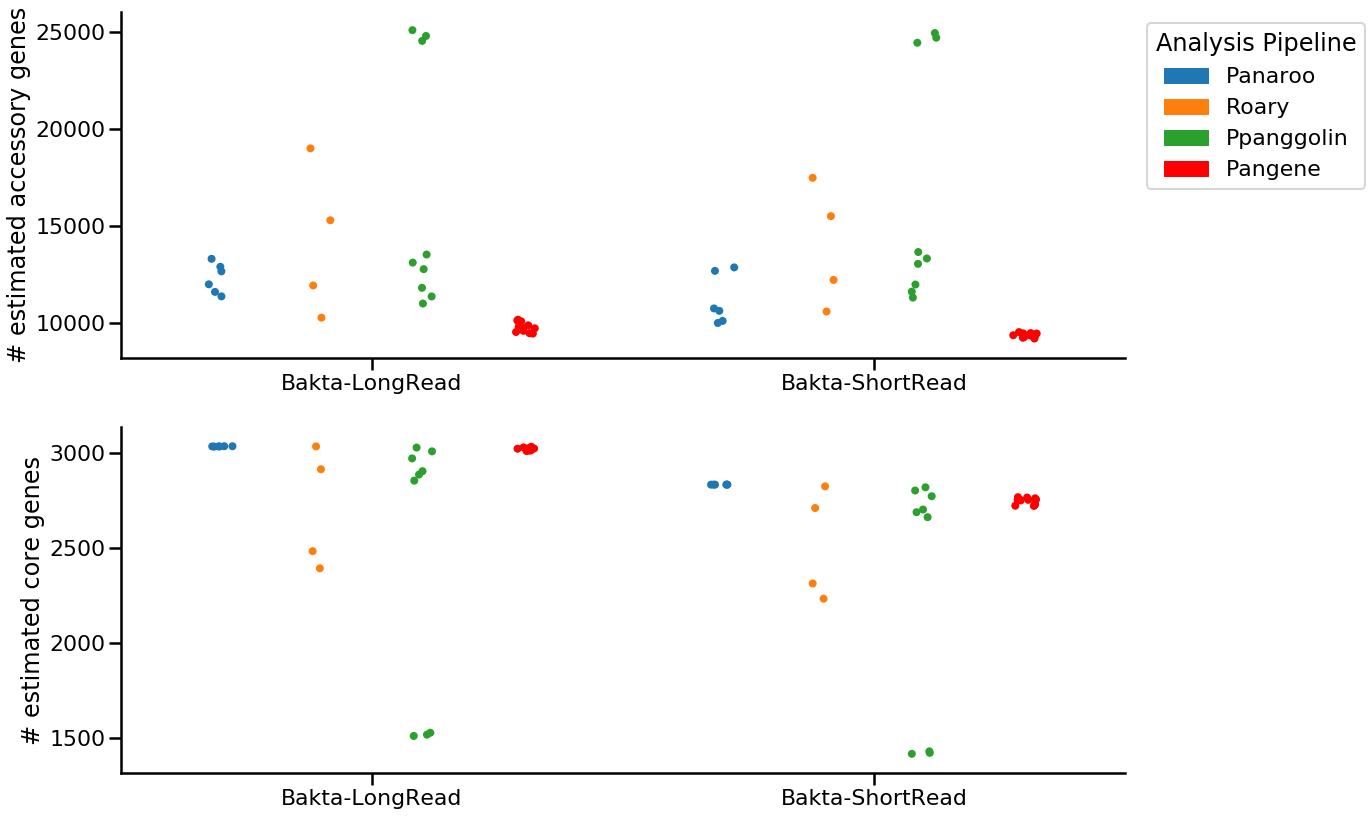

In [99]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
#             hue_order = hue_Order_Tools,
#             #order = Order_AnnoAndType,
#             ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
#             hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
#             ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

sns.despine()

plt.show()

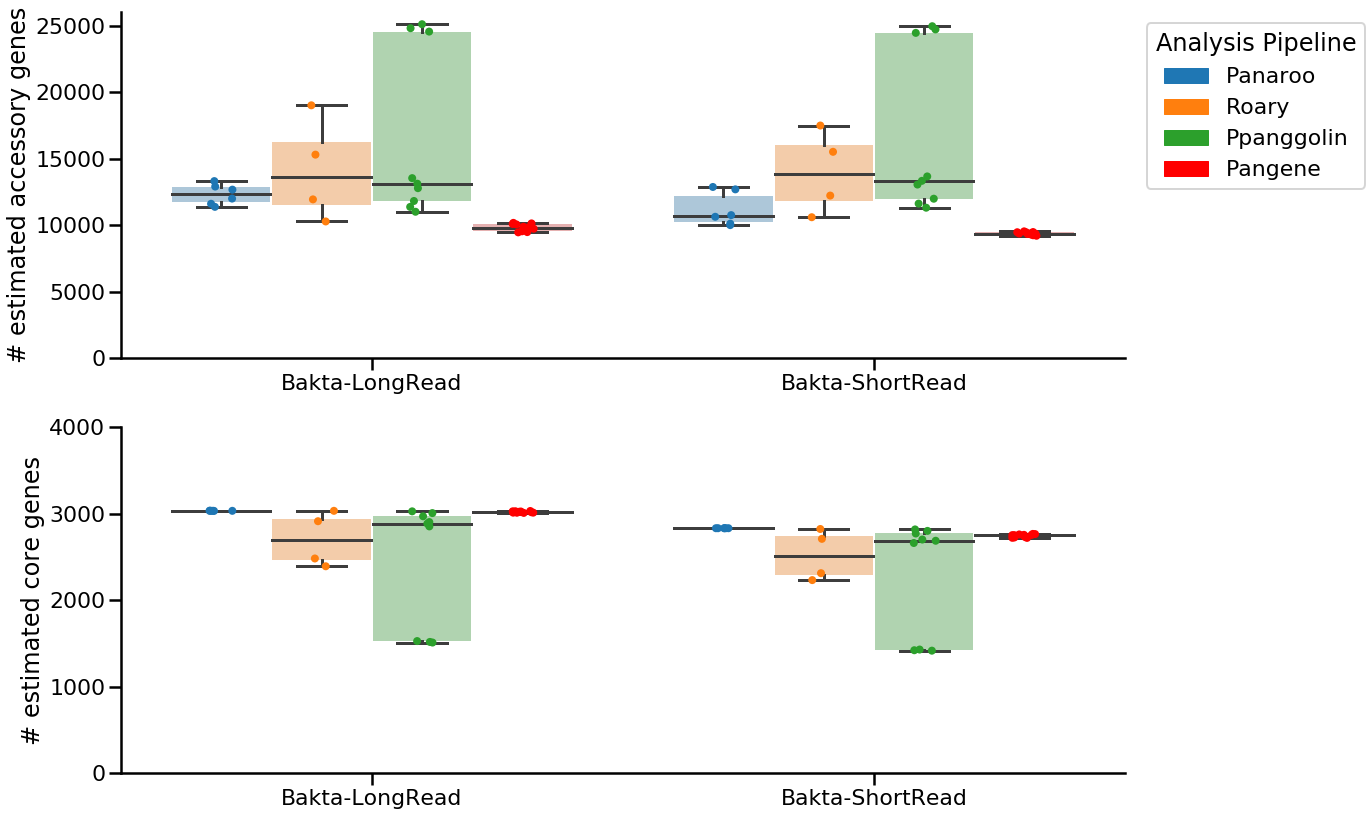

In [100]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
            data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
            hue_order = hue_Order_Tools,
            #order = Order_AnnoAndType,
            ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
            data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
            hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
            ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

axs[0].set_ylim(0, 26000)
axs[1].set_ylim(0, 4000)

sns.despine()

plt.show()

# Viz results coloring by Anno-AsmType combinations

In [101]:
AnnoAndTech_hue_Color_Dict = { "Bakta-LongRead": "#1f77b4",
                               #"PGAP-LongRead": "#2ca02c",
                               "Bakta-ShortRead": "#ff7f0e", }
                               #"PGAP-ShortRead": "#9467bd" }

Bakta_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-LongRead"],
                                     label='Bakta & Complete Assemblies (N=50)')
Bakta_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-ShortRead"],
                                   label='Bakta & Short-Read Assemblies (N=50)')

AnnoAndTech_Patches = [Bakta_CompAsm_patch, Bakta_SRAsm_patch]

hue_orderToPlot_V2 = ["Bakta-LongRead",  "Bakta-ShortRead", ]

hue_orderToPlot_X = AnnoAndTech_hue_Color_Dict.keys()
pallete_ForPlot = AnnoAndTech_hue_Color_Dict.values()


In [102]:
AnnoAndTech_hue_Color_Dict

{'Bakta-LongRead': '#1f77b4', 'Bakta-ShortRead': '#ff7f0e'}

In [103]:
AnnoAndTech_hue_Color_Dict

{'Bakta-LongRead': '#1f77b4', 'Bakta-ShortRead': '#ff7f0e'}

In [104]:
pallete_ForPlot

dict_values(['#1f77b4', '#ff7f0e'])

In [106]:
AnnoAndTech_hue_Color_Dict

{'Bakta-LongRead': '#1f77b4', 'Bakta-ShortRead': '#ff7f0e'}

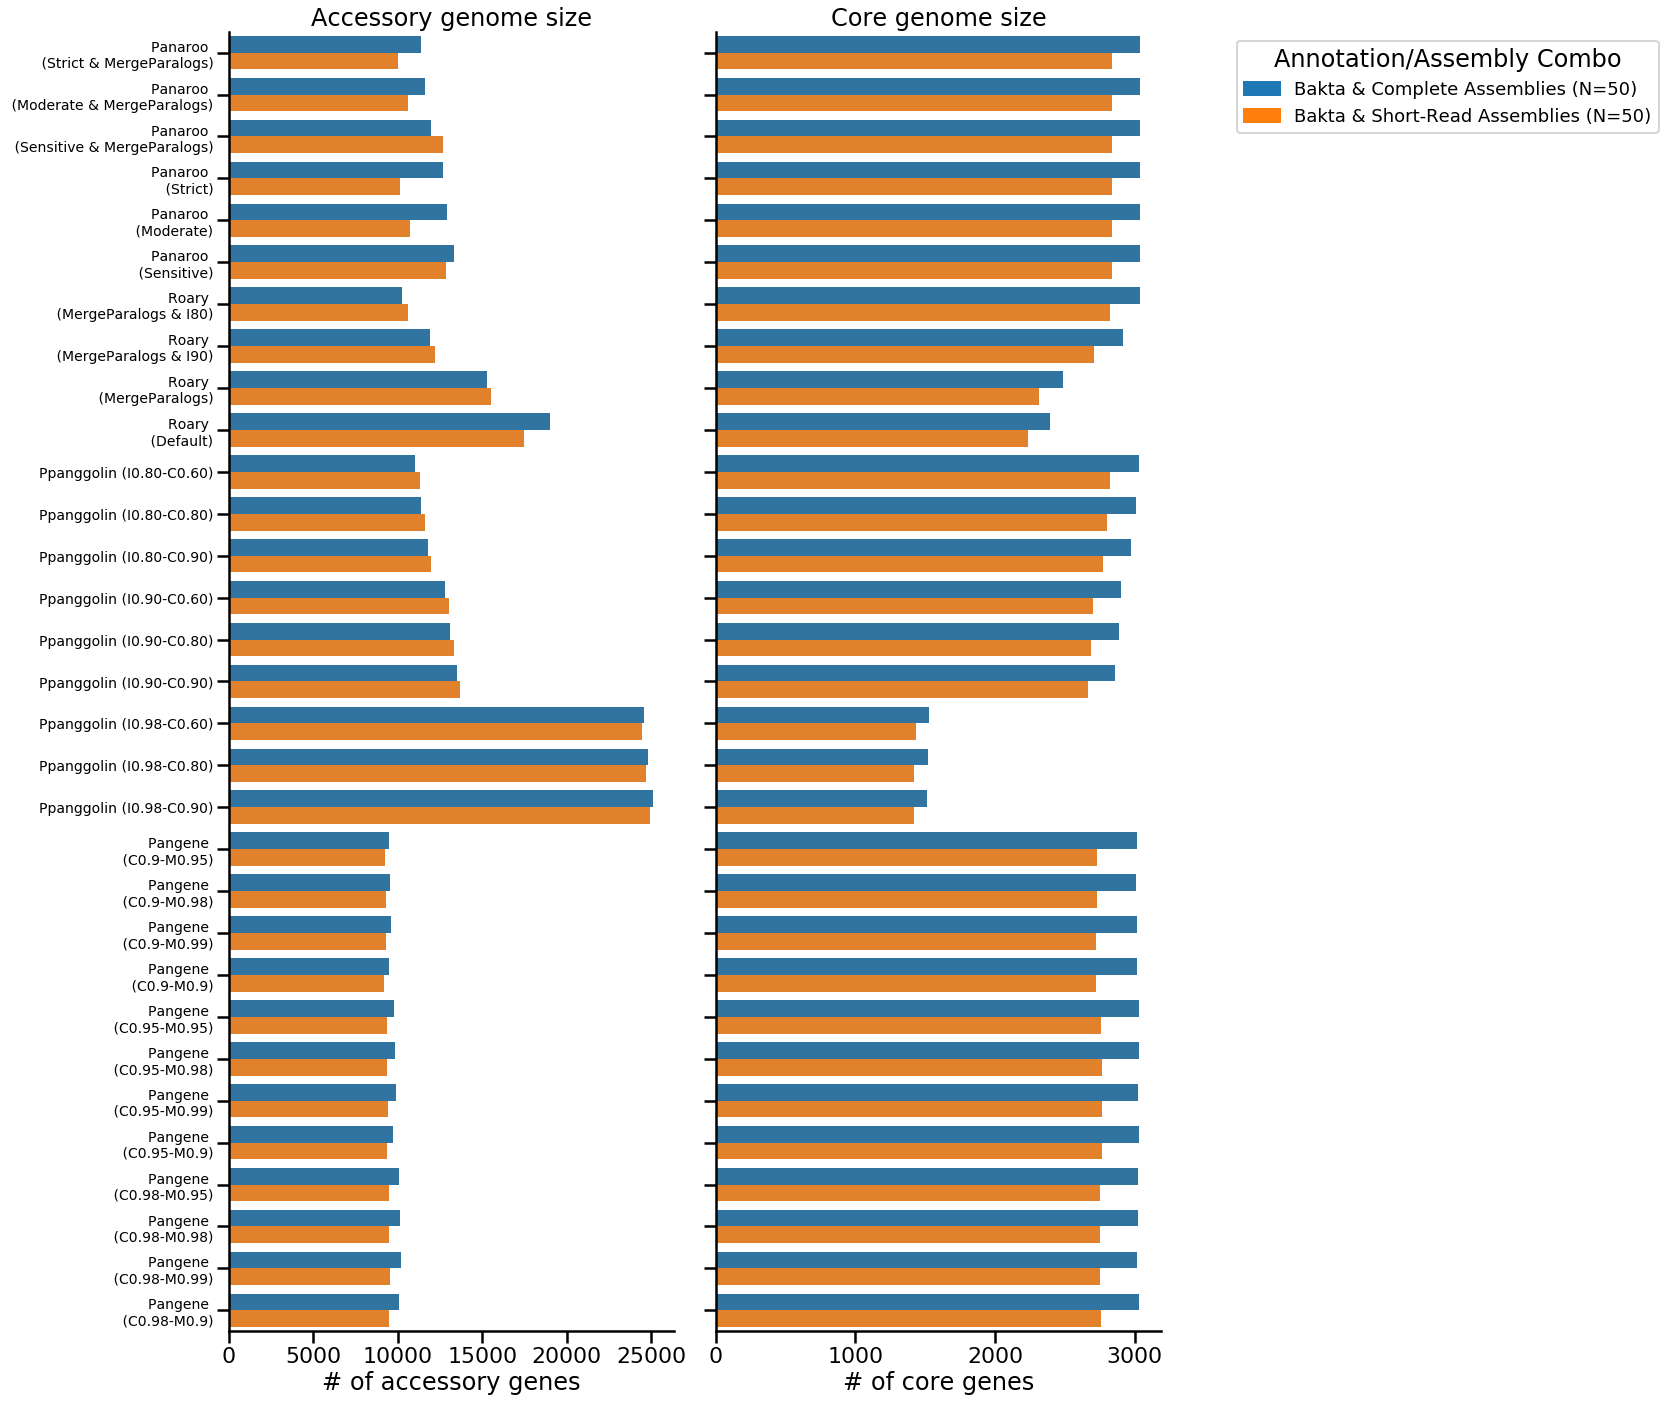

In [107]:
# Change the subplot configuration to 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(24, 20), sharex=False, sharey=True)
sns.set_context("poster")

hue_orderToPlot_X = AnnoAndTech_hue_Color_Dict.keys()
pallete_ForPlot = AnnoAndTech_hue_Color_Dict.values()

# Plotting on the first and second subplot
sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Acc_DF,
            order=PipeName_WiParam_List, hue_order=hue_orderToPlot_V2, ax=axs[0], palette=pallete_ForPlot)

sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Core_DF,
            order=PipeName_WiParam_List, hue_order=hue_orderToPlot_V2, ax=axs[1], palette=pallete_ForPlot)

# Set labels
axs[0].set_ylabel("") # Adjust as needed
axs[1].set_ylabel("") # Adjust as needed
axs[0].set_xlabel("# of accessory genes", rotation=0)
axs[1].set_xlabel("# of core genes", rotation=0)

# Set tick labels
for i_ax in axs:
    i_ax.set_yticklabels(labels=PGCombos_TickLabels, rotation=0, fontdict={"fontsize": 14})

axs[1].legend(title = "Annotation/Assembly Combo", handles = AnnoAndTech_Patches,
              bbox_to_anchor=(1.15, 1), fontsize= 18) 
axs[0].get_legend().remove(), 

# Set titles
axs[0].set_title("Accessory genome size")
axs[1].set_title("Core genome size")

# Despine and layout adjustment
sns.despine()
plt.tight_layout()

#plt.savefig("Results3_Plots/3.PG.Counts.SRvsLR.AND.BaktaVsPGAP.CombinedCoreAccPlots.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results3_Plots/3.PG.Counts.SRvsLR.AND.BaktaVsPGAP.CombinedCoreAccPlots.svg", bbox_inches="tight")

plt.show()